In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image

# Sanity

In [2]:
raw = pd.read_csv('../AVA/AVA_dataset/AVA.txt', sep=' ', header=None)
raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,953619,0,1,5,17,38,36,15,6,5,1,1,22,1396
1,2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396
2,3,954184,0,0,4,8,41,56,10,3,4,0,0,0,1396
3,4,954113,0,1,4,6,48,37,23,5,2,2,15,21,1396
4,5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396


In [3]:
len(raw)

255530

In [4]:
not_exists = [953619, 953958, 954184, 954113, 953980, 954175, 953349, 953645, 953897, 953841, 310261, 848725, 444892, 567829, 398594, 638163, 397289, 104855, 11066, 148477, 52365, 430454]
not_loads =  [440774, 179118, 371434, 277832, 230701, 729377] # 906653
len(not_exists), len(not_loads)

(22, 6)

In [15]:
def check_id(id, images_dir):
    img_path = os.path.join(images_dir, f'{id}.jpg')
    if not os.path.exists(img_path):
        return 1
    try:
        Image.open(img_path).load()
    except:
        return 2
    return 0

# Call this to conduct checking with actual downloaded images
def check(df: pd.DataFrame, images_dir):
    not_exists = []
    not_loaded = []
    for ind, row in enumerate(df.iloc):
        status = check_id(row[1], images_dir)
        if status == 1: not_exists.append(row[1])
        elif status == 2: not_loaded.append(row[1])
        if status > 0:
            print('Found invalid image at', ind)
    return not_exists, not_loaded

In [6]:
remove_indexes = raw[raw[1].isin(set(not_exists).union(not_loads))].index
raw_checked = raw.drop(index=remove_indexes)
raw_checked.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
10,11,953417,0,0,0,5,32,50,23,10,3,1,22,0,1396
11,12,953777,0,3,2,3,13,40,35,21,8,3,20,53,1396
12,13,953756,0,2,3,9,35,50,20,5,2,2,0,0,1396
13,14,954195,0,1,7,26,56,23,6,1,0,2,0,0,1396
14,15,953903,0,1,4,5,33,50,17,9,3,2,21,28,1396


# Transform Data

In [7]:
def _votes2possibilities(row):
    id = row[1]
    votes = np.array(row[2:12])
    total = sum(votes)
    poss = votes / total
    if total <= 0:
        print(id, votes[votes < 0], total)
    return pd.Series([id, *list(poss)])

def votes2possibilities(df: pd.DataFrame):
    res = df.apply(_votes2possibilities, axis=1)
    res = res.astype({0: int})
    return res

In [8]:
data = votes2possibilities(raw_checked)
data.head()

,0,1,2,3,4,5,6,7,8,9,10
10,953417,0.0,0.000000,0.000000,0.040323,0.258065,0.403226,0.185484,0.080645,0.024194,0.008065
11,953777,0.0,0.023438,0.015625,0.023438,0.101562,0.312500,0.273438,0.164062,0.062500,0.023438
12,953756,0.0,0.015625,0.023438,0.070312,0.273438,0.390625,0.156250,0.039062,0.015625,0.015625
13,954195,0.0,0.008197,0.057377,0.213115,0.459016,0.188525,0.049180,0.008197,0.000000,0.016393
14,953903,0.0,0.008065,0.032258,0.040323,0.266129,0.403226,0.137097,0.072581,0.024194,0.016129


In [9]:
# Save all to file
data.to_csv('ava.csv', header=None, index=None)

# Convert to Mean and Std

In [10]:
def _summarize(row):
    poss = np.array(row[1:])
    score_range = np.arange(1, 11)
    score = sum(poss * score_range)
    std = sum(poss * ((score_range - score) ** 2)) ** 0.5
    return pd.Series([row[0], score, std])

def summarize(df: pd.DataFrame):
    res = df.apply(_summarize, axis=1)
    res = res.astype({0: int})
    res.columns = ['id','mean','std']
    return res

In [11]:
sum_data = summarize(data)
sum_data.head()

,id,mean,std
10,953417,6.112903,1.123141
11,953777,6.593750,1.491840
12,953756,5.796875,1.295180
13,954195,5.040984,1.176251
14,953903,5.943548,1.321671


In [12]:
# save all to file
sum_data.to_csv('./summary.csv', header=['id','mean','std'], index=None)

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

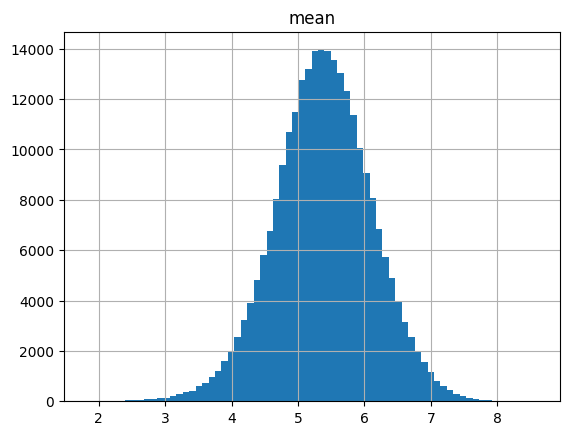

In [13]:
sum_data.hist('mean', bins=70)

array([[<Axes: title={'center': 'std'}>]], dtype=object)

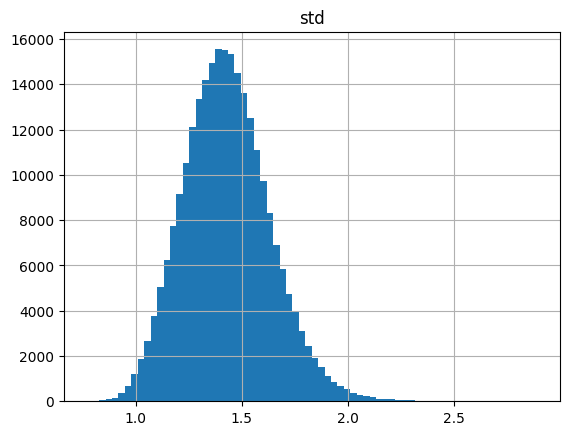

In [14]:
sum_data.hist('std', bins=70)